# FACEBOOK DATA FROM YAHOO FINANCE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("C:/Users/ASUS/Desktop/FMI/Licenta OB/Overall Code/packtpub-notebooks/packtpub-src/csv/FB2012-2019.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-29,31.480000,31.690001,28.650000,28.840000,28.840000,78063400
1,2012-05-30,28.700001,29.549999,27.860001,28.190001,28.190001,57267900
2,2012-05-31,28.549999,29.670000,26.830000,29.600000,29.600000,111639200
3,2012-06-01,28.889999,29.150000,27.389999,27.719999,27.719999,41855500
4,2012-06-04,27.200001,27.650000,26.440001,26.900000,26.900000,35230300


In [4]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1755,2019-05-21,184.570007,185.699997,183.889999,184.820007,184.820007,7502800
1756,2019-05-22,184.729996,186.740005,183.610001,185.320007,185.320007,9213800
1757,2019-05-23,182.419998,183.899994,179.669998,180.869995,180.869995,12768800
1758,2019-05-24,182.330002,183.630005,180.830002,181.059998,181.059998,8807700
1759,2019-05-28,181.539993,184.710007,181.449997,184.309998,184.309998,14843300


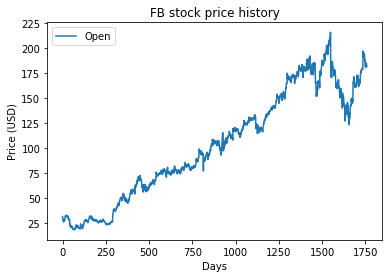

In [5]:
plt.figure()
plt.title("FB stock price history")
plt.plot(df['Open'])
#plt.plot(df["Close"])
#plt.plot(df["High"])
#plt.plot(df["Low"])
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open', 'Close', 'High', 'Low'], loc='upper left')
plt.show()

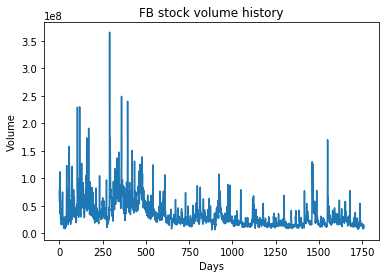

In [6]:
plt.figure()
plt.plot(df['Volume'])
plt.title('FB stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
print('Checking if any null values are present\n', df.isna().sum())

Checking if any null values are present
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### Normalizing the data
* Split the data into train, test
* Normalize
* Covert the DataFrame to ndarray

In [8]:
#! pip install keras

In [9]:
#! pip install np_utils

In [10]:
#! pip install tensorflow

In [11]:
#! pip install numpy --upgrade --user

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier as knn

print('Checking GPU available', K.tensorflow_backend._get_available_gpus())


Using TensorFlow backend.


Checking GPU available []


In [13]:
from keras import losses

In [14]:
TIME_STEPS = 60
BATCH_SIZE = 20

In [15]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

In [16]:

train_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print('Train and test set', len(df_train), len(df_test))

#scale the feature MinMax, build array
x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and test set 1408 352


In [17]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total nb of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    
    print('length of time-series i/o', x.shape, y.shape)
    return x, y

In [18]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0] % batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [19]:
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)


length of time-series i/o (1348, 60, 5) (1348,)



length of time-series i/o (292, 60, 5) (292,)


In [20]:
type(x_t)
x_t.shape
x_t[:, :, :1].shape

(1340, 60, 1)

In [21]:
print(x_t.shape)

(1340, 60, 5)


In [22]:
 x_t = x_t[:, :, 0]
x_temp = x_temp[:, :, 0]
# x_test = x_test.reshape((x_test.shape[0], 1))
# x_t.reshape(x_t.shape[0], -1)



In [23]:
print(x_t.shape)
print(x_test.shape)

(1340, 60)
(352, 5)


In [24]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error", error, y_pred.shape, y_test_t.shape)

y_pred_orig = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_test_t_orig = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

NameError: name 'model' is not defined

In [ ]:
#from strategy import *

In [ ]:
x_t.shape

In [ ]:
y_t.shape

In [ ]:
x_temp.shape

In [ ]:
y_temp.shape

# Linear Regressor

In [25]:
benchmark_model = LinearRegression()
benchmark_model.fit(x_t, y_t)
y_test_pred = benchmark_model.predict(x_temp)

In [26]:
error = mean_squared_error(y_test_pred, y_temp)
print(error)

0.0008740562971972318


In [ ]:
import pickle

filename = 'linearRegressorFB.sav'
pickle.dump(benchmark_model, open(filename, 'wb'))

In [ ]:
y_test_pred.shape

In [ ]:
y_temp.shape

In [27]:
y_test_pred_orig = (y_test_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_temp_orig = (y_temp * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

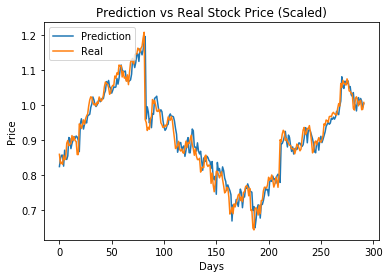

In [28]:
plt.figure()
plt.plot(y_test_pred)
plt.plot(y_temp)
plt.title('Prediction vs Real Stock Price (Scaled)')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

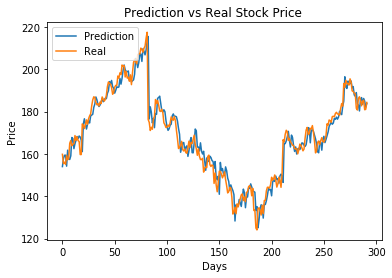

In [29]:
plt.figure()
plt.plot(y_test_pred_orig)
plt.plot(y_temp_orig)
plt.title('Prediction vs Real Stock Price ')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [42]:
real_data = y_temp_orig[-140:]
predicted_data = y_test_pred_orig[-140:]

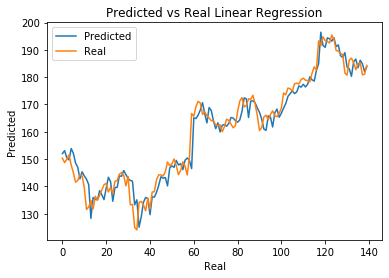

In [43]:
plt.figure()
plt.plot(predicted_data)
plt.plot(real_data)
plt.title('Predicted vs Real Linear Regression')
plt.ylabel('Predicted')
plt.xlabel('Real')
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [37]:
benchmark_model.coef_

array([-1.45114278e-02,  1.09437361e-02,  3.31078958e-02, -1.16318552e-02,
       -1.16902288e-03, -2.26657183e-02,  6.40032299e-02,  3.09478960e-02,
       -4.66265190e-02,  4.02397262e-02, -5.15994685e-02,  2.94801848e-03,
       -1.61294014e-02,  6.14277821e-02,  8.91836967e-03, -5.23816364e-02,
       -3.93594369e-02,  1.67360429e-03,  1.41809587e-02, -3.56429687e-04,
       -1.95444140e-02, -1.78500422e-02,  6.43509688e-02, -3.37661954e-03,
       -3.99844414e-02,  4.56383247e-02, -4.18876261e-02, -2.18009010e-02,
        1.16882235e-02,  4.80872466e-02, -4.49285665e-03, -1.18285513e-03,
       -3.06125911e-02,  1.84320436e-02,  1.19573298e-02, -6.60670849e-03,
        1.61753091e-02, -3.75122486e-02,  2.81133241e-02, -4.73838733e-02,
       -3.69420142e-02,  1.39851600e-02,  5.81114815e-02, -2.05099224e-02,
        3.06007391e-02, -5.42520205e-02,  2.74050534e-02,  5.81683462e-02,
        5.07459033e-03,  1.70020910e-02, -5.10416855e-02, -1.78667649e-02,
        2.41933703e-02, -

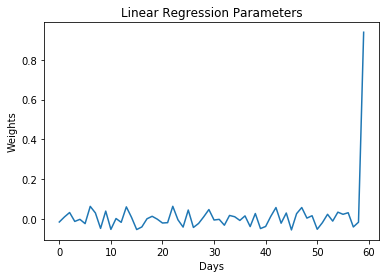

In [40]:
plt.figure()
plt.plot(benchmark_model.coef_)
plt.title('Linear Regression Parameters')
plt.xlabel('Days')
plt.ylabel('Weights')
plt.show()

In [ ]:
class strategy():
    def __init__(self):
        self.stocks = 0
    
    def take_action(self, today_real_price, tomorrow_forcasted_price):
        """
         At day t, an investor buys one share of INTC stock if the predicted price 
         is higher than the current actual adjusted closing price.
         Otherwise, he or she sells one share of INTC stock"""
        if tomorrow_forcasted_price > today_real_price:
            self.stocks += 1
        else:
            self.stocks -= 1
    
    def compute_daily_return(self, today_real_price, tomorrow_real_price):
        """
         Using the
indicator variable st
, we can calculate a daily return of
the strategy at day t + 1:
rt+1 = st × log 
yt+1
yt

−
        """
        import math
        daily_return = self.stocks * math.log(tomorrow_real_price, today_real_price)
        return daily_return
            

In [ ]:
def execute_strategy(strategy, predicted_data, verbose=True):
    """
    args: strategy to execute
    """
    cumulative_return = 0
    for day, today_real_price in enumerate(real_data[:-1]):
        # day by day and execute my strategy
        today_predicted_price = predicted_data[day]
        if verbose: print(day, today_real_price, today_predicted_price)
        
        strategy.take_action(today_real_price, predicted_data[day + 1])
        today_return = strategy.compute_daily_return(today_real_price, real_data[day + 1])
        # metric: cumulative return
        # sum of all the returns
        cumulative_return += today_return
    return cumulative_return

In [ ]:
regressor_strategy = strategy()
regression_predicted_data = y_test_pred_orig # TODO: find this
real_data = y_temp_orig
regression_strategy_return = execute_strategy(regressor_strategy, regression_predicted_data, verbose=False)
regressor_strategy.stocks
print(regression_strategy_return)

In [ ]:
def directional_accuracy(predicted_data, real_data):
    """return the nb of days that the model got the movement right / nb of days in total
    args:
        predicted_data:
    """        
    days_predicted = len(real_data) 
    nb_correct_pred = 0
    
    for t in range(days_predicted-1):
        if (predicted_data[t+1] - predicted_data[t]) * (real_data[t+1] - real_data[t]) > 0:
            nb_correct_pred += 1
    return nb_correct_pred / (days_predicted - 1) # movements in the market = nb of pred days - 1



In [ ]:
#prints directional accuracy for linear regressor
print(directional_accuracy(y_test_pred, y_temp))

# SVM 

In [ ]:
benchmark_model = SVR()
benchmark_model.fit(x_t, y_t)
y_test_pred_svm = benchmark_model.predict(x_temp)

error = mean_squared_error(y_test_pred, y_temp)
print(error)


In [ ]:
y_test_pred_svm = (y_test_pred_svm * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_pred)
y_temp = (y_temp * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] #min_max_scaler.inverse_transform(y_test_t)

In [ ]:
plt.figure()
plt.plot(y_test_pred_svm)
plt.plot(y_temp)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()

In [ ]:
svm_strategy = strategy()
svm_predicted_data = y_test_pred_svm # TODO: find this
real_data = y_temp_orig
svm_strategy_return = execute_strategy(svm_strategy, svm_predicted_data, verbose=False)
svm_strategy.stocks
print(svm_strategy_return)

In [ ]:
# do gridsearch, put logging into
# what overfit would mean here?
# read lstm AK
# how to appreciate how good is the prediction?

# sentiment analysis for stock prediction ? X



In [ ]:
# KNN Classifier is a classifier; We modeled this as a regression problem

benchmark_model = knn()
benchmark_model.fit(x_t, y_t)
y_test_pred = benchmark_model.predict(x_temp)

error = mean_squared_error(y_test_pred, y_temp)
print(error)
